In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

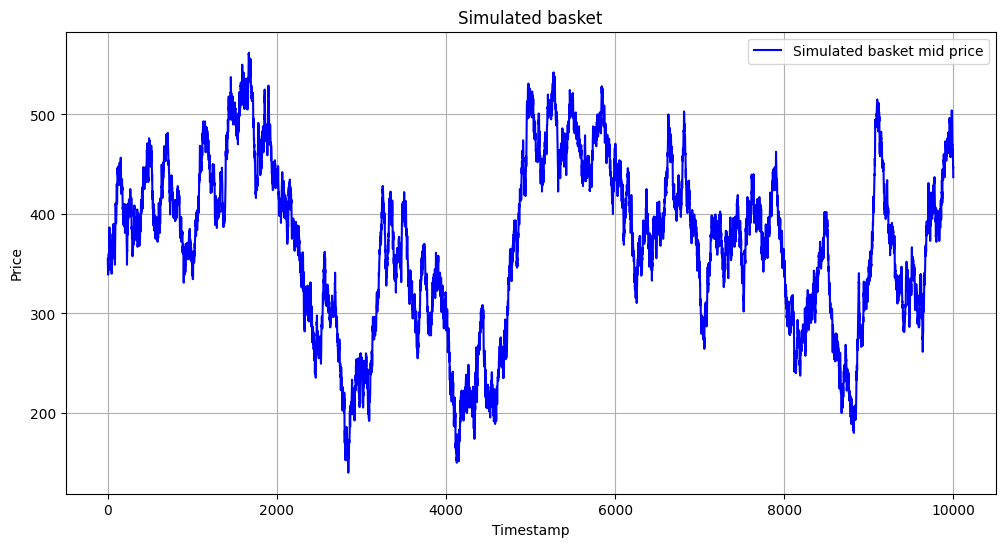

370.2306


In [39]:
csv_file_path = "./data/round_3/prices_round_3_day_0.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])

data = {}
stat = 'mid_price'

for prod in products:
    data[prod] = df[df['product'] == prod]
    
plt.figure(figsize=(12, 6))
plt.plot(data["GIFT_BASKET"][stat].values - (6 * data["STRAWBERRIES"][stat].values + 4 * data["CHOCOLATE"][stat].values + data["ROSES"][stat].values), 
         marker='', linestyle='-', color='b', label="Simulated basket mid price")
# plt.plot(data["GIFT_BASKET"]["ask_price_1"].values, 
#          marker='', linestyle='-', color='r', label="Real basket mid price")
plt.title("Simulated basket")
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()

print(np.mean(data["GIFT_BASKET"][stat].values - (6 * data["STRAWBERRIES"][stat].values + 4 * data["CHOCOLATE"][stat].values + data["ROSES"][stat].values)))

# for prod in products:
#     
#     plt.figure(figsize=(12, 6))
#     plt.plot(data[prod][stat], marker='', linestyle='-', color='b', label="Mid price")
#     plt.title(prod)
#     plt.xlabel("Timestamp")
#     plt.ylabel("Price"),
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    

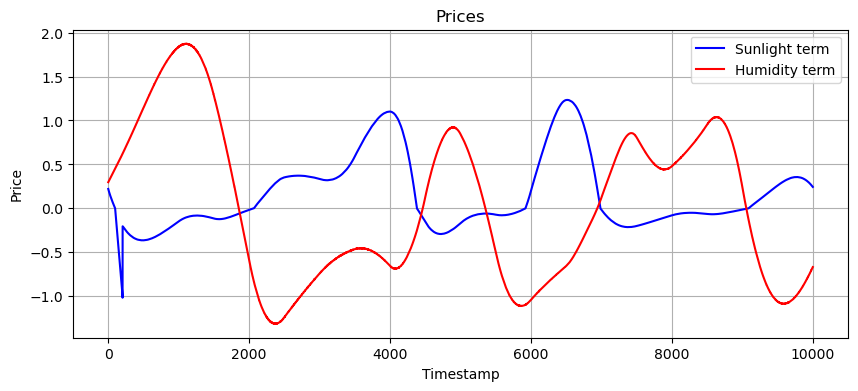

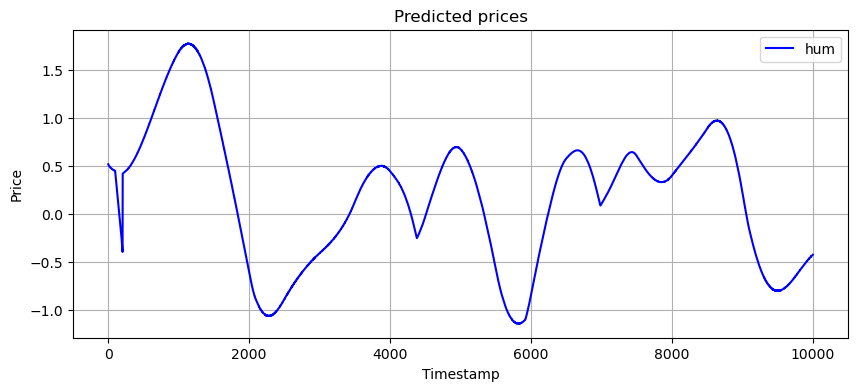

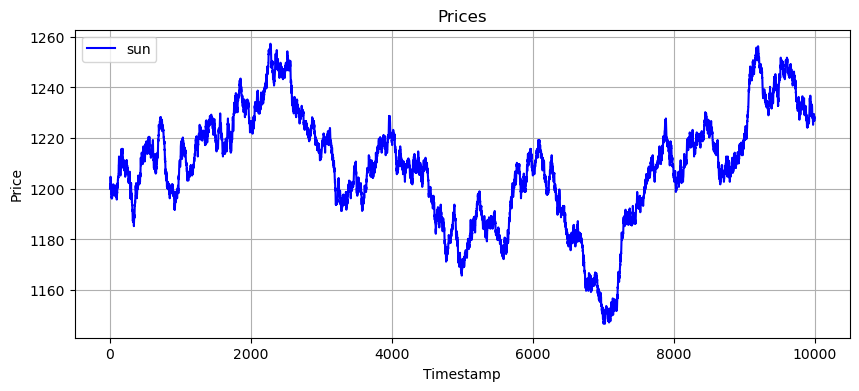

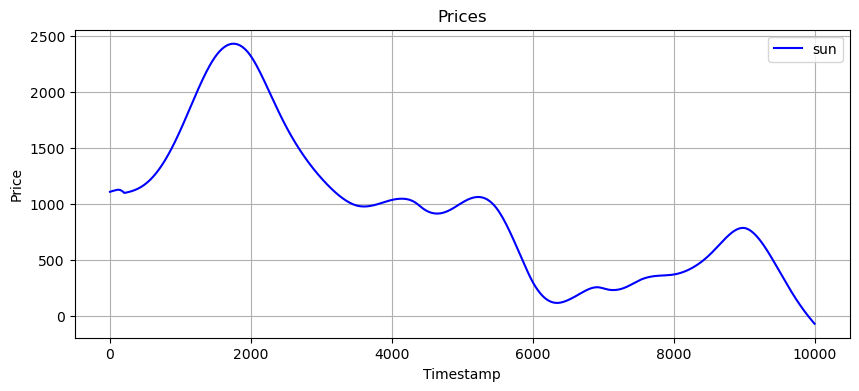

In [71]:
csv_file_path_round_2 = "./data/round_2/prices_round_2_day_-1.csv"
df2 = pd.read_csv(csv_file_path_round_2, sep=';')

prices = []
hum = 'HUMIDITY'
sun = 'SUNLIGHT'
# current_price = 1200
# min_sunlight = 10000 / 24 * 7 # 7 hours of sunlight
# sunlight_diff = min_sunlight / 42 # the sunlight drop that would cause 1% decrease in production
# humidity_diff = 2.5

# for idx in range(len(df2)):
#     current_humidity = df2['HUMIDITY'][idx]
#     current_sunlight = df2['SUNLIGHT'][idx]
#     
#     abs_dif_humidity = 0
#     if current_humidity < 60 or current_humidity > 80:
#         abs_dif_humidity = max(60-current_humidity, current_humidity - 80)
#     elif current_sunlight > min_sunlight:
#         current_price = 1200
#         
#     
#     abs_dif_sunlight = 0
#     if current_sunlight < min_sunlight:
#         abs_dif_sunlight = min_sunlight - current_sunlight
#         
#     percent_change_hum = abs_dif_humidity / humidity_diff
#     percent_change_sunlight = abs_dif_sunlight / sunlight_diff
#     
#     total_percent_change = percent_change_sunlight + percent_change_hum
#     
#     current_price = current_price - total_percent_change / 10000 * current_price
#     
#     prices.append(current_price)

diff_hum = []
diff_sun = []
forecasts = []
pred_prices = []
hum_terms = []
sun_terms = []
prev_price = 1110
for idx in range(3,len(df2)):
    curr_sunlight = df2[sun][idx]
    curr_diff_hum = (df2[hum][idx] - df2[hum][idx-1]) * 80
    curr_diff_sun = df2[sun][idx] - df2[sun][idx-1]
    diff_sun.append(curr_diff_sun)
    diff_hum.append(curr_diff_hum)
    
    sunlight_term = 2 * -curr_diff_sun * (1 - np.sqrt(abs(df2[sun][idx] - 2500) / 2500))

    if (curr_sunlight > 2500 and curr_diff_sun > 0) or (curr_sunlight < 2500 and curr_diff_sun < 0):
        sunlight_term /= 5
    humidity_term = curr_diff_hum * (df2[hum][idx] - 70) / 5 / 1.5
    sun_terms.append(sunlight_term)
    hum_terms.append(humidity_term)
    forecast = sunlight_term + humidity_term
    forecasts.append(forecast)
    pred_price = prev_price + (forecast - 0.3) 
    prev_price = pred_price
    pred_prices.append(pred_price)

plt.figure(figsize=(10, 4))
plt.plot(sun_terms, marker='', linestyle='-', color='b', label='Sunlight term')
plt.plot(hum_terms, marker='', linestyle='-', color='r', label='Humidity term')
plt.title('Prices')
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 4))
plt.plot(forecasts, marker='', linestyle='-', color='b', label='hum')
plt.title('Predicted prices')
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df2['ORCHIDS'], marker='', linestyle='-', color='b', label='sun')
plt.title('Prices')
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pred_prices, marker='', linestyle='-', color='b', label='sun')
plt.title('Prices')
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()